In [1]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

train_path = 'images/processed/train'
valid_path = 'images/processed/test'

IMAGE_SIZE = [100, 100]
epochs = 5
batch_size = 32

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')

folders = glob(train_path+'/*')

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

In [2]:
vgg = VGG16(input_shape=IMAGE_SIZE +[3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs = vgg.input, outputs = prediction)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [4]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics=['accuracy']
)

gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = preprocess_input
)

In [5]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 197 images belonging to 4 classes.
{'face': 0, 'face1': 1, 'face2': 2, 'face3': 3}


min:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 -108.26466 max: 98.690315


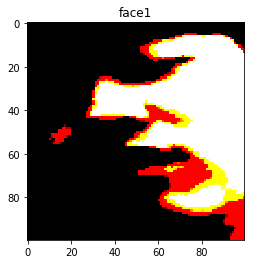

In [6]:
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k
    
for x,y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [7]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 1753 images belonging to 4 classes.
Found 197 images belonging to 4 classes.


In [8]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files)//batch_size,
    validation_steps=len(valid_image_files)//batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
54/54 [==============================] - 150s 3s/step - loss: 1.1271 - acc: 0.8177 - val_loss: 0.5299 - val_acc: 0.8958
Epoch 2/5
54/54 [==============================] - 145s 3s/step - loss: 0.1816 - acc: 0.9564 - val_loss: 0.2384 - val_acc: 0.9455
Epoch 3/5
54/54 [==============================] - 149s 3s/step - loss: 0.0972 - acc: 0.9763 - val_loss: 0.1866 - val_acc: 0.9697
Epoch 4/5
54/54 [==============================] - 158s 3s/step - loss: 0.0637 - acc: 0.9815 - val_loss: 0.0819 - val_acc: 0.9818
Epoch 5/5
54/54 [==============================] - 155s 3s/step - loss: 0.0648 - acc: 0.9896 - val_loss: 0.0883 - val_acc: 0.9758


In [9]:
def get_confusion_matrix(data_path, N):
    print("Generation confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size*2):
        i+=1
        if not i%50:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
            
    cm = confusion_matrix(targets, predictions)
    return cm

cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

print(r.history.keys())

Generation confusion matrix 1753
Found 1753 images belonging to 4 classes.
[[448   1   1   0]
 [  1 405   2   0]
 [  0   2 447   1]
 [  0   2   1 442]]
Generation confusion matrix 197
Found 197 images belonging to 4 classes.
[[50  0  0  0]
 [ 0 45  0  1]
 [ 0  0 50  1]
 [ 0  1  0 49]]
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


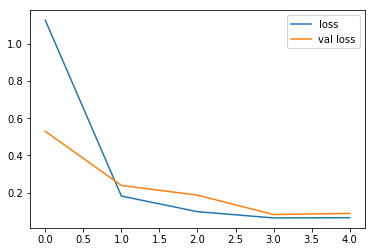

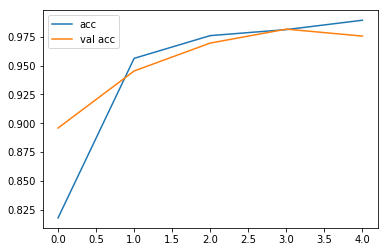

In [10]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [11]:
import cv2
import os

In [12]:
BASE_DIR = os.path.dirname(os.path.abspath(''))
print("[INFO] Loading Caffe model...")
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
kernel = np.ones((20, 20), np.float32) / 400
print("[INFO] Starting video encoding...")
cap = cv2.VideoCapture('video.mp4')
writer = None
face_names = ['sangjun', 'taekjung', 'taejong', 'yongdae']
fsize = (300, 300)

[INFO] Loading Caffe model...
[INFO] Starting video encoding...


In [13]:
while cap.isOpened():
    _, frame = cap.read()
    if frame is None:
        break

    if writer is None:
        writer = cv2.VideoWriter('video_vgg.mp4', fourcc, 30, (frame.shape[1], frame.shape[0]))

    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, fsize, interpolation=cv2.INTER_AREA), 1.0, fsize, (104.0, 177.0, 123.0))

    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if 0 > detections[0, 0, i, 3] or detections[0, 0, i, 3] > 1 or 0 > detections[0, 0, i, 4] \
                or detections[0, 0, i, 4] > 1 or 0 > 0 or detections[0, 0, i, 5] > 1 \
                or 0 > detections[0, 0, i, 6] or detections[0, 0, i, 6] > 1 or confidence < 0.8:
            continue
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        roi = frame[startY:endY, startX:endX]
        roi = cv2.resize(roi, (100, 100), interpolation=cv2.INTER_AREA)
        roi = np.expand_dims(roi, axis=0)
        text = str(face_names[np.argmax(model.predict(roi), axis=1)[0]])
        cv2.putText(frame, text, (startX, startY), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
    writer.write(frame)

writer.release()
cv2.destroyAllWindows()
cap.release()